## Load libraries and data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from imblearn.under_sampling import RandomUnderSampler

import warnings 
warnings.filterwarnings('ignore')

In [11]:
# Load train and test data
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

In [12]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

### Undersampling majority class: Random Undersampling

In [13]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

# Randomly sample test dataset
print(f'Fraud proportion in original test data: {test_df['is_fraud'].mean()}')

test_not_fraud = test_df.loc[test_df['is_fraud'] == 0].sample(22000, random_state = 123)
test_fraud = test_df.loc[test_df['is_fraud'] == 1].sample(100, random_state = 123)
test_sample_df = pd.concat([test_fraud, test_not_fraud])

print(f'Fraud proportion in sample test dataset; {test_sample_df['is_fraud'].mean()}')

X_test = test_sample_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_sample_df['is_fraud']
print(f'Size of test dataset after random undersampling: {len(y_test)}')


Size of X_train after random undersampling: 21888
Fraud proportion in original test data: 0.0032388145877671527
Fraud proportion in sample test dataset; 0.004524886877828055
Size of test dataset after random undersampling: 22100


### Oversampling minority class: SMOTE-NC

In [14]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.6)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

In [15]:
len(X_train_smote.columns)

29

### One-hot encoding (for random forest)

In [16]:
# Apply one-hot encoding on train and test data
X_train_ohe = pd.get_dummies(X_train_smote)
X_test_ohe = pd.get_dummies(X_test)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

In [17]:
len(X_train_ohe.columns)

1191

### Feature selection: SelectKBest

In [21]:
print(f'Number of columns before feature selection: {len(X_train_ohe.columns)}')

selector = SelectKBest(score_func=f_classif, k=30)
X_train_kbest = selector.fit_transform(X_train_ohe,y_train_smote)
X_test_kbest = selector.transform(X_test_ohe)

Number of columns before feature selection: 1191


## Base model

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=6, random_state=123)
clf.fit(X_train_kbest, y_train_smote)

RandomForestClassifier(max_depth=6, random_state=123)

In [25]:
y_pred = clf.predict(X_test_kbest)
print(f'accuracy: {accuracy_score(y_test, y_pred)}, precision: {precision_score(y_test, y_pred, average='macro', zero_division = 0.0)}, recall: {recall_score(y_test, y_pred, average='macro')}, f1: {f1_score(y_test, y_pred, average='macro', zero_division = 0.0)}')

accuracy: 0.9994117647058823, precision: 0.9459232073038977, recall: 0.9947272727272727, f1: 0.9690465485824278


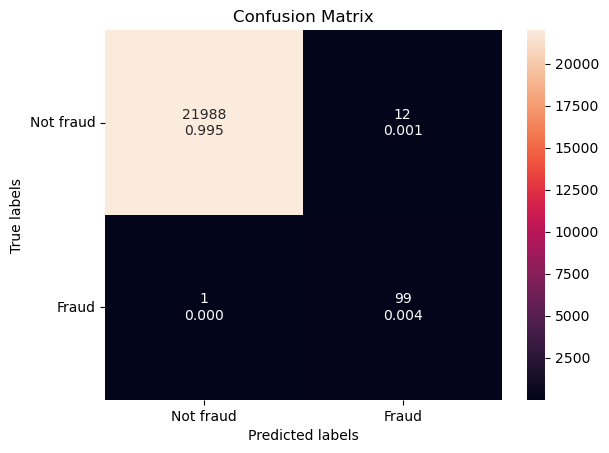

In [31]:
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)

group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

sns.heatmap(cm, annot=values, fmt='')
# sns.heatmap(cm, annot=True, fmt='.3f', ax=ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

## With GridSearchCV

In [33]:
from sklearn.model_selection import GridSearchCV
clf2 = RandomForestClassifier(random_state=123)

params = {'n_estimators': [100, 200, 300], 
         'max_features': ['sqrt', 'log2', 20],
         'max_depth': [5, 10, 15, 20],
         'criterion': ['gini', 'entropy']}
cv = GridSearchCV(estimator = clf2, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'f1')

cv.fit(X_train_kbest, y_train_smote)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   2.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   2.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   2.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   2.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   2.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200; total time=   5.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200; total time=   5.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200; total time=   5.6s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=100; total time=   2.3s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200; total time=   5.5

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'max_features': ['sqrt', 'log2', 20],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=2)

In [38]:
print(f'Chosen hyperparameters: {cv.best_params_}')
cv_best_model = cv.best_estimator_
print(f'CV F1: {round(cv.best_score_, 2)}')

y_pred_cv = cv_best_model.predict(X_test_kbest)
print(f'Test accuracy: {accuracy_score(y_test, y_pred_cv)}, precision: {precision_score(y_test, y_pred_cv, average='macro', zero_division = 0.0)}, recall: {recall_score(y_test, y_pred_cv, average='macro')}, f1: {f1_score(y_test, y_pred_cv, average='macro', zero_division = 0.0)}')

importance= pd.DataFrame({
    'Feature': selector.get_feature_names_out(),
    'Importance': cv_best_model.feature_importances_
})

print('\nTop 10 most important features:')
importance.sort_values(by='Importance', ascending=False)[:10]

Chosen hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}
CV F1: 1.0
Test accuracy: 0.9995022624434389, precision: 0.9541057037929195, recall: 0.9947727272727273, f1: 0.9735591849529031

Top 10 most important features:


,Feature,Importance
4,count_fraud_prev10,0.240012
3,prev_trans_fraud,0.221124
0,amt,0.138113
7,merchant_count_fraud_prev10,0.110437
6,merchant_prev_trans_fraud,0.075745
13,visited_cat,0.072186
5,acc_fraud_count,0.028995
1,hour,0.023636
10,hourly_risk_score,0.023587
15,amt_deviation,0.022250


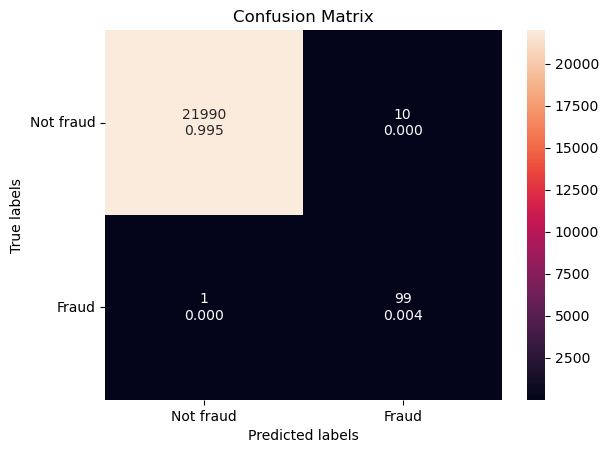

In [39]:
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred_cv)

group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

sns.heatmap(cm, annot=values, fmt='')
# sns.heatmap(cm, annot=True, fmt='.3f', ax=ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()